In [5]:
import h5py
import cv2
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import os, sys, numpy as np
import torch
from torch.utils.data import sampler, DataLoader
from skimage.transform import resize

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from sononet.utils.util import json_file_to_pyobj
from sononet.models import get_model
from sononet.dataio.loader import get_dataset, get_dataset_path
from sononet.dataio.transformation import get_dataset_transformation
from sononet.utils.visualiser import Visualiser
from sononet.utils.error_logger import ErrorLogger
from sononet.models.networks_other import adjust_learning_rate

ModuleNotFoundError: No module named 'sononet.models'

# Data & Options

In [2]:
json_filename = 'configs/config_sononet_8_6classes.json'
json_opts = json_file_to_pyobj(json_filename)
train_opts = json_opts.training

In [3]:
us_data = h5py.File('data/image_inp_224x288.hdf5')

In [4]:
cardiac_classes = [1, 2, 22, 29]
other_classes = [4, 15, 31]
all_classes = cardiac_classes + other_classes
class_dict = {1:0, 29:0, 2:1, 22:2, 4:3, 15:4, 31:5}
class_names = dict(zip([class_dict[c] for c in all_classes], us_data['label_names'].value[[c for c in all_classes]]))
for i in class_names.keys():
    class_names[i] = class_names[i].decode('utf8')
class_names[0] = 'RVOT/3VV'

In [5]:
train_id = np.array([i in all_classes for i in us_data['plane_labels_train'].value])
test_id = np.array([i in all_classes for i in us_data['plane_labels_test'].value])

In [6]:
images_train = torch.tensor(us_data['images_train'][train_id,:,:,:])
labels_train = torch.tensor([class_dict[lab] for lab in us_data['plane_labels_train'][train_id]])

images_test = torch.tensor(us_data['images_test'][test_id,:,:,:])
labels_test = torch.tensor([class_dict[lab] for lab in us_data['plane_labels_test'][test_id]])

In [7]:
from PIL import Image

In [15]:
for idx, image in enumerate(images_train):
    img = Image.fromarray(image[0].numpy())
    img.save('img/img-{:04d}.png'.format(idx))

In [7]:
arch_type = train_opts.arch_type
ds_transform = get_dataset_transformation(arch_type, opts=json_opts.augmentation)



############# Augmentation Parameters #############
{'division_factor': (16, 16, 1),
 'inten_val': (1.0, 1.0),
 'name': 'us',
 'patch_size': [208, 272],
 'random_flip_prob': 0.5,
 'rotate_val': 15.0,
 'scale_size': (192, 192, 1),
 'scale_val': (0.7, 1.3),
 'shift_val': (0.1, 0.1)}
###################################################




# Dataset Classes

In [8]:
class SimpleUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target)

    def __len__(self):
        return len(self.images)

In [9]:
class AlteredUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]
        self.embedding = data[2]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]
        emb = self.embedding[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target), emb

    def __len__(self):
        return len(self.images)

# Datasets & Loaders

In [10]:
train_dataset = SimpleUSDataset(
    (images_train, labels_train),
    transform=ds_transform['train'])
train_dataset_for_acc = SimpleUSDataset(
    (images_train, labels_train),
    transform=ds_transform['valid'])
test_dataset = SimpleUSDataset(
    (images_test, labels_test),
        transform=ds_transform['valid'])

In [11]:
batch_size = 100
train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, len(train_dataset), replacement=True)

In [12]:
train_loader = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True)
#    sampler=train_sampler)

train_loader_for_acc = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

test_loader  = DataLoader(test_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

# Model & Training

In [13]:
def print_accuracy(model, fold):
    model.net.eval()
    if fold == 'train':
        loader = train_loader_for_acc
    elif fold == 'test':
        loader = test_loader
    labels = []
    preds = []
    for (img, lab) in loader:
        labels.append(lab.cpu())
        model.set_input(img)
        model.forward(split='test')
        preds.append(model.logits.cpu().argmax(dim=1))
    labels = torch.cat(labels)
    preds = torch.cat(preds)
    acc = (labels==preds).sum().float() / len(labels)
    print('Accuracy {fold}: {acc}'.format(
        fold=fold, acc=acc
    ))
    return acc

In [14]:
model = get_model(json_opts.model)


Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(

In [15]:
model.set_labels([0,1,2,3,4,5])
model.set_scheduler(train_opts)
model.load_network(model.net, '6classes_base', 5)
model.update_state(0)

opt.lr_policy = [step_warmstart]
Scheduler is added for optimiser SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.010000000000000002
    momentum: 0.9
    nesterov: True
    weight_decay: 1e-06
)
Loading the model 6classes_base - epoch 5


In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic=True

model = get_model(json_opts.model)
model.update_state(0)
model.optimizer.param_groups[0]['lr'] = 0.1

for epoch in tqdm(range(1, 11)):
    for (images, labels) in train_loader:
        # Make a training update
        model.net.train()
        model.set_input(images, labels)
        model.optimize_parameters()

    model.save_network(model.net, '6classes_base', epoch, model.gpu_ids)
        #print_accuracy(model, 'train')
        #print_accuracy(model, 'test')

#    if epoch == 15:
#        model.optimizer.param_groups[0]['lr'] = 0.01


  0%|          | 0/10 [00:00<?, ?it/s]
Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), 

In [16]:
def get_logits(model, fold, softmax=True):
    model.net.eval()
    with torch.no_grad():
        if fold == 'train':
            loader = train_loader_for_acc
        elif fold == 'test':
            loader = test_loader
        elif fold == 'train_aug':
            loader = train_loader
        labels = []
        logits = []
        for (img, lab) in loader:
            labels.append(lab.cpu())
            model.set_input(img)
            model.forward(split='test')
            if softmax:
                logits.append(model.logits.cpu())
            else:
                logits.append(model.prediction.cpu())
        if fold == 'train_aug':
            for (img, lab) in loader:
                labels.append(lab.cpu())
                model.set_input(img)
                model.forward(split='test')
                if softmax:
                    logits.append(model.logits.cpu())
                else:
                 logits.append(model.prediction.cpu())
        labels = torch.cat(labels)
        logits = torch.cat(logits)
        return logits, labels

In [18]:
logits_train_before, labels_train = get_logits(model, 'train', softmax=False)

In [226]:
logits_train_before_aug, labels_train_aug = get_logits(model, 'train_aug', softmax=False)

# Embedding

In [7]:
import sys
sys.path.append('../ptsne-pytorch')
from ptsne.ptsne import ParametricTSNE

In [20]:
ptsne = ParametricTSNE(6, 2, 50, use_cuda=True, hidden_layer_dims=[300,100], alpha='learn')

In [21]:
ptsne.load_state_dict(torch.load('checkpoints/ifind1_sononet_8_6classes/ptsne.pt'))

<All keys matched successfully>

In [228]:
ptsne.fit(logits_train_before_aug, pretrain=True, verbose=True)

Calculating PCA
2020-03-15 00:42:08.477923: Beginning pretraining for 5 epochs
2020-03-15 00:42:08.714948: Loss after epoch 0: 24.12006613612175
2020-03-15 00:42:08.897955: Loss after epoch 1: 1.2107548955827951
2020-03-15 00:42:09.086953: Loss after epoch 2: 0.185385184828192
2020-03-15 00:42:09.252953: Loss after epoch 3: 0.04488978104200214
2020-03-15 00:42:09.429953: Loss after epoch 4: 0.021000108623411506
2020-03-15 00:42:09.429953: Finished pretraining
Indexing
Calculating probabilities: 9554/95542020-03-15 00:42:53.533639: Beginning training for 10 epochs
2020-03-15 00:42:54.268609: Loss after epoch 1: 40.83706347399874
2020-03-15 00:42:54.944610: Loss after epoch 2: 36.250422944377966
2020-03-15 00:42:55.614611: Loss after epoch 3: 34.60851854612146
2020-03-15 00:42:56.304133: Loss after epoch 4: 33.98331357635376
2020-03-15 00:42:56.985162: Loss after epoch 5: 31.966870833580888
2020-03-15 00:42:57.687625: Loss after epoch 6: 31.065983987695258
2020-03-15 00:42:58.384943: Los

In [238]:
projected = ptsne(logits_train_before.cuda()).cpu().detach()

In [239]:
true_idx = logits_train_before.softmax(dim=1).argmax(dim=1) == labels_train

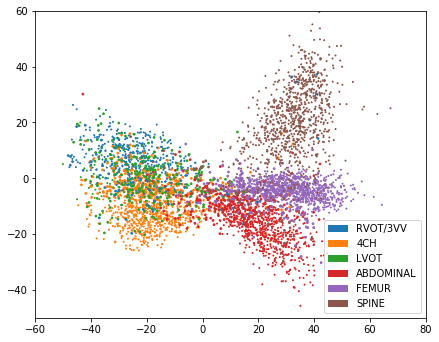

In [240]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[label] for label in labels_train]
#colors = [plt.cm.tab10.colors[label] if true_idx[idx] else 'black' for idx, label in enumerate(labels_train)]
sizes = [1 if i else 3 for i in true_idx]
ax.scatter(projected[:,0], projected[:,1], c=colors, s=sizes)
ax.set_aspect(1)
ax.set_xlim([-60,80])
ax.set_ylim([-50,60])
recs = []
for i in range(0,6):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i for i in class_names.values()],loc=4)

# Latent Constraints

In [242]:
shifted_train = projected.clone()
shifted_train[labels_train == 0] = (1./2. * projected[(labels_train == 0)] + 1./2. * projected[(labels_train == 0)].mean(axis=0)) + torch.tensor([-7.,10.])
shifted_train[labels_train == 1] = (3./4. * projected[(labels_train == 1)] + 1./4. * projected[(labels_train == 1)].mean(axis=0)) + torch.tensor([-5.,-10.])
shifted_train[labels_train == 2] = (1./2. * projected[(labels_train == 2)] + 1./2. * projected[(labels_train == 2)].mean(axis=0)) + torch.tensor([2.,-2.])
    #(5./6. * projected[(labels_train == 0)] + 1./6. * projected[(labels_train == 0)].mean(axis=0)) + torch.tensor([0.,1.]),
    #(3./4. * projected[(labels_train == 1)] + 1./4. * projected[(labels_train == 1)].mean(axis=0)) + torch.tensor([0.,0.]),
    #(2./3. * projected[(labels_train == 2)] + 1./3. * projected[(labels_train == 2)].mean(axis=0)) + torch.tensor([5.,0.]),

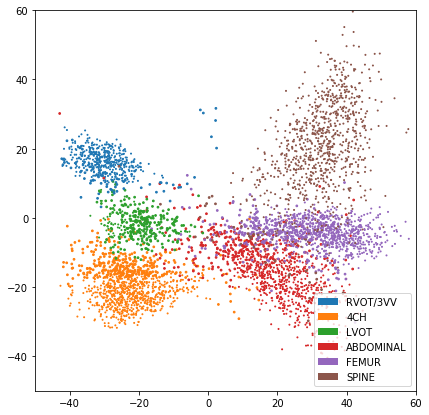

In [243]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[label] for label in labels_train]
#colors = [plt.cm.tab10.colors[label] if true_idx[idx] else 'black' for idx, label in enumerate(labels_train)]
sizes = [1 if i else 3 for i in true_idx]
ax.scatter(shifted_train[:,0], shifted_train[:,1], c=colors, s=sizes)
ax.set_aspect(1)
ax.set_xlim([-50,60])
ax.set_ylim([-50,60])
recs = []
for i in range(0,6):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i for i in class_names.values()],loc=4)

In [32]:
torch.save(ptsne.state_dict(), 'checkpoints/ifind1_sononet_8_6classes/ptsne.pt')

# Retraining

In [244]:
#train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, len(train_dataset), replacement=True)
#train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, 2000)
shifted_dataset = AlteredUSDataset((images_train, labels_train, shifted_train), transform=ds_transform['valid'])
shifted_loader = DataLoader(shifted_dataset, batch_size=100, shuffle=True)

In [246]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic=True

emb_weight = 0.
exp_name = 'class' if emb_weight == 0.0 else 'emb{:03d}'.format(int(10*emb_weight))
model = get_model(json_opts.model)
model.load_network(model.net, '6classes_base', 5)
model.update_state(0)
model.optimizer.param_groups[0]['lr'] = 0.01

for epoch in tqdm(range(1, 9)):
    for batch, (images, labels, emb) in enumerate(shifted_loader):
        # Make a training update
        model.set_input(images, labels)
        c_loss, e_loss = model.optimize_parameters_altered(ptsne, emb.cuda(), emb_weight,
            return_losses=True, classes=[0,1,2])

        with open('6_classes_' + exp_name + '.txt', 'a') as text_file:
            print('Ep {ep}, batch {batch}: Cl. loss = {cl}, Emb. loss = {el}'.format(
            ep=epoch, batch=batch, cl=c_loss, el=e_loss), file=text_file)

    model.save_network(model.net, '6classes_new_noaug_' + exp_name, epoch+5, model.gpu_ids)

0%|          | 0/8 [00:00<?, ?it/s]
Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
logits_base = {'train':[], 'test':[]}
for epoch in range(1, 6):
    model.load_network(model.net, '6classes_base', epoch)
    logits_base['train'].append(get_logits(model, 'train', softmax=False)[0])
    logits_base['test'].append(get_logits(model, 'test', softmax=False)[0])
logits_base['train'] = torch.stack(logits_base['train'])
logits_base['test'] = torch.stack(logits_base['test'])
torch.save(logits_base, 'checkpoints/ifind1_sononet_8_6classes/logits_base.pt')

Loading the model 6classes_base - epoch 1
Loading the model 6classes_base - epoch 2
Loading the model 6classes_base - epoch 3
Loading the model 6classes_base - epoch 4
Loading the model 6classes_base - epoch 5


In [247]:
logits_emb = {'train':[], 'test':[]}
for epoch in range(1, 9):
    model.load_network(model.net, '6classes_new_noaug_emb001', epoch+5)
    logits_emb['train'].append(get_logits(model, 'train', softmax=False)[0])
    logits_emb['test'].append(get_logits(model, 'test', softmax=False)[0])
logits_emb['train'] = torch.stack(logits_emb['train'])
logits_emb['test'] = torch.stack(logits_emb['test'])
torch.save(logits_emb, 'checkpoints/ifind1_sononet_8_6classes/logits_new_noaug_emb_001.pt')

Loading the model 6classes_new_noaug_emb001 - epoch 6
Loading the model 6classes_new_noaug_emb001 - epoch 7
Loading the model 6classes_new_noaug_emb001 - epoch 8
Loading the model 6classes_new_noaug_emb001 - epoch 9
Loading the model 6classes_new_noaug_emb001 - epoch 10
Loading the model 6classes_new_noaug_emb001 - epoch 11
Loading the model 6classes_new_noaug_emb001 - epoch 12
Loading the model 6classes_new_noaug_emb001 - epoch 13


In [248]:
logits_class = {'train':[], 'test':[]}
for epoch in range(1, 9):
    model.load_network(model.net, '6classes_new_noaug_class', epoch+5)
    logits_class['train'].append(get_logits(model, 'train', softmax=False)[0])
    logits_class['test'].append(get_logits(model, 'test', softmax=False)[0])
logits_class['train'] = torch.stack(logits_class['train'])
logits_class['test'] = torch.stack(logits_class['test'])
torch.save(logits_class, 'checkpoints/ifind1_sononet_8_6classes/logits_new_noaug_class.pt')

Loading the model 6classes_new_noaug_class - epoch 6
Loading the model 6classes_new_noaug_class - epoch 7
Loading the model 6classes_new_noaug_class - epoch 8
Loading the model 6classes_new_noaug_class - epoch 9
Loading the model 6classes_new_noaug_class - epoch 10
Loading the model 6classes_new_noaug_class - epoch 11
Loading the model 6classes_new_noaug_class - epoch 12
Loading the model 6classes_new_noaug_class - epoch 13


In [1]:
true_idx_class = logits_class['test'][-2].softmax(dim=1).argmax(dim=1) == labels_test
projected_class = ptsne(logits_class['test'][-2].cuda()).cpu().detach()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[label] if true_idx_class[idx] else 'black' for idx, label in enumerate(labels_train)]
ax.scatter(projected_class[:,0], projected_class[:,1], c=colors, s=sizes)
ax.set_aspect(1)
ax.set_xlim([-50,60])
ax.set_ylim([-50,60])
recs = []
for i in range(0,6):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i for i in class_names.values()],loc=4)

NameError: name 'logits_class' is not defined

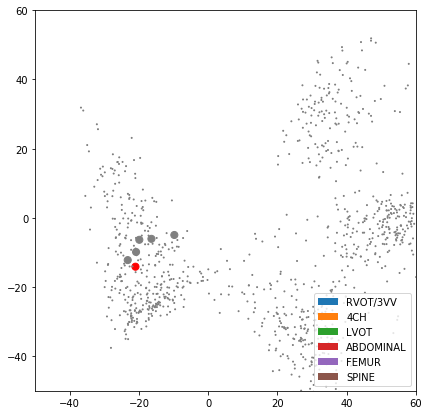

In [148]:
true_idx_emb = logits_emb['test'][-2].softmax(dim=1).argmax(dim=1) == labels_test
projected_emb = ptsne(logits_emb['test'][-2].cuda()).cpu().detach()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[label] if true_idx_emb[idx] else 'black' for idx, label in enumerate(labels_train)]
colors = np.array([(0.5,0.5,0.5) for label in labels_test])
colors[169] = (1.,0.,0.)
ax.scatter(projected_emb[:,0], projected_emb[:,1], c=colors, s=sizes)
ax.set_aspect(1)
ax.set_xlim([-50,60])
ax.set_ylim([-50,60])
recs = []
for i in range(0,6):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i for i in class_names.values()],loc=4)

In [15]:
def confmat(data):
    num_classes = len(np.unique(data[1]))
    cf = torch.zeros(num_classes,num_classes, dtype=torch.int)
    for logits, label, in zip(*data):
        cf[label, logits.softmax(dim=0).argmax()] += 1
    return cf

In [16]:
def accuracy(data):
    cf = confmat(data)
    diag = cf.diagonal().sum()
    total = cf.sum()
    return diag.float() / total

In [17]:
def precision(data, c):
    cf = confmat(data)
    return cf[c,c].float() / cf[:,c].sum().float()

In [18]:
def recall(data, c):
    cf = confmat(data)
    return cf[c,c].float() / cf[c,:].sum().float()

In [19]:
def f_score(data, c):
    cf = confmat(data)
    prec = cf[c,c].float() / cf[:,c].sum().float()
    rec = cf[c,c].float() / cf[c,:].sum().float()
    return torch.sqrt(prec * rec)

In [33]:
accuracy((logits_class['test'][-2], labels_test))

tensor(0.8858)

In [34]:
confmat((logits_class['test'][-2], labels_test))

tensor([[ 32,  27,  24,   0,   0,   0],
        [  3, 232,   8,   3,   0,   0],
        [  4,  23,  23,   0,   0,   0],
        [  0,   1,   0, 216,   4,   3],
        [  0,   1,   0,   6, 266,   2],
        [  0,   0,   0,   8,   2, 154]], dtype=torch.int32)

In [35]:
[recall((logits_class['test'][-2], labels_test), i) for i in range(6)]

[tensor(0.3855),
 tensor(0.9431),
 tensor(0.4600),
 tensor(0.9643),
 tensor(0.9673),
 tensor(0.9390)]

In [36]:
[precision((logits_class['test'][-2], labels_test), i) for i in range(6)]

[tensor(0.8205),
 tensor(0.8169),
 tensor(0.4182),
 tensor(0.9270),
 tensor(0.9779),
 tensor(0.9686)]

In [24]:
[f_score((logits_class['test'][-2], labels_test), i) for i in range(6)]

[tensor(0.5624),
 tensor(0.8777),
 tensor(0.4386),
 tensor(0.9455),
 tensor(0.9726),
 tensor(0.9537)]

In [32]:
accuracy((logits_emb['test'][-2], labels_test))

tensor(0.9040)

In [26]:
confmat((logits_emb['test'][-2], labels_test))

tensor([[ 61,  13,   9,   0,   0,   0],
        [  7, 231,   0,   8,   0,   0],
        [ 10,  25,  14,   0,   0,   1],
        [  0,   1,   0, 215,   5,   3],
        [  0,   1,   0,   4, 267,   3],
        [  0,   0,   0,   8,   2, 154]], dtype=torch.int32)

In [27]:
[recall((logits_emb['test'][-2], labels_test), i) for i in range(6)]

[tensor(0.7349),
 tensor(0.9390),
 tensor(0.2800),
 tensor(0.9598),
 tensor(0.9709),
 tensor(0.9390)]

In [28]:
[precision((logits_emb['test'][-2], labels_test), i) for i in range(6)]

[tensor(0.7821),
 tensor(0.8524),
 tensor(0.6087),
 tensor(0.9149),
 tensor(0.9745),
 tensor(0.9565)]

In [29]:
[f_score((logits_emb['test'][-2], labels_test), i) for i in range(6)]

[tensor(0.7581),
 tensor(0.8947),
 tensor(0.4128),
 tensor(0.9371),
 tensor(0.9727),
 tensor(0.9477)]

In [73]:
class_names

{0: 'RVOT/3VV', 1: '4CH', 2: 'LVOT', 3: 'ABDOMINAL', 4: 'FEMUR', 5: 'SPINE'}

In [70]:
np.unique(labels_train,return_counts=True)[1]

array([ 509, 1025,  332,  927, 1066,  918], dtype=int64)

In [61]:
([f_score((logits_class['test'][-2], labels_test), i) for i in range(3)] * counts[:3]).sum() / counts[:3].sum()

0.750749773589162

In [64]:
([f_score((logits_class['test'][-2], labels_test), i) for i in range(3,6)] * counts[3:]).sum() / counts[3:].sum()

0.9587522844923028

In [ ]:
f_score_0_test_class = [f_score((log, labels_test), 0) for log in logits_class['test']]
f_score_1_test_class = [f_score((log, labels_test), 1) for log in logits_class['test']]
f_score_2_test_class = [f_score((log, labels_test), 2) for log in logits_class['test']]
f_score_3_test_class = [f_score((log, labels_test), 3) for log in logits_class['test']]

In [108]:
f_score_0_test_emb = [f_score((log, labels_test), 0) for log in logits_emb['test']]
f_score_1_test_emb = [f_score((log, labels_test), 1) for log in logits_emb['test']]
f_score_2_test_emb = [f_score((log, labels_test), 2) for log in logits_emb['test']]
f_score_3_test_emb = [f_score((log, labels_test), 3) for log in logits_emb['test']]

In [18]:
logits_class = torch.load('checkpoints/ifind1_sononet_8_6classes/logits_new_noaug_class.pt')
logits_emb = torch.load('checkpoints/ifind1_sononet_8_6classes/logits_new_noaug_emb_001.pt')

In [7]:
projected_class = ptsne(logits_class['train'][-1].cuda()).cpu().detach()
projected_emb = ptsne(logits_emb['train'][-1].cuda()).cpu().detach()

In [275]:
projected_emb = ptsne(logits_train_before.cuda()).cpu().detach()
np.savetxt('projected_shifted.csv', shifted_train, delimiter=',')

In [58]:
np.savetxt('labels_test.csv', labels_test.numpy())

In [17]:
model.net.load_state_dict(torch.load('checkpoints/ifind1_sononet_8_6classes/011_net_6classes_new_noaug_class.pth'))

<All keys matched successfully>

In [4]:
logits = torch.cat((
    torch.load('checkpoints/ifind1_sononet_8_6classes/logits_base.pt')['train'],
    torch.load('checkpoints/ifind1_sononet_8_6classes/logits_new_noaug_emb_001.pt')['train']
))

In [5]:
logits.shape

torch.Size([13, 4777, 6])

In [8]:
ptsne = ParametricTSNE(6, 2, 50, use_cuda=True, hidden_layer_dims=[300,100], alpha='learn')
ptsne.load_state_dict(torch.load('checkpoints/ifind1_sononet_8_6classes/ptsne.pt'))

<All keys matched successfully>

In [11]:
coords = ptsne(logits.reshape(-1,6).cuda()).cpu().detach().numpy()

In [15]:
np.savetxt('animation_data.csv', coords, delimiter=',')